In [1]:
%matplotlib inline
import matplotlib.pylab as plt

from matplotlib import rc, animation, patches
rc('animation', html='html5')

import numpy as np
import scipy.integrate as integrate

from scipy.linalg import solve_continuous_are

### Define the dynamical system

In [2]:
g = 9.81
l_1 = 1.0 
m_1 = 1.0 
m_c = 1.0 

In [3]:
def make_deriv(f=lambda state, t, args: 0): 

    def deriv(state, t, args): 
        dydx = np.zeros_like(state)

        x, theta1, x_dot, theta1_dot = state

        dydx[0] = x_dot
        dydx[1] = theta1_dot

        cos_theta1 = np.cos(theta1)
        sin_theta1 = np.sin(theta1)

        ft = f(state, t, args)

        A = np.array([
            [m_1 + m_c, m_1*l_1*cos_theta1],
            [m_1*l_1*cos_theta1, m_1*l_1*l_1]
        ])
        b = np.array([
            ft + sin_theta1*l_1*m_1*theta1_dot*theta1_dot,
            -m_1*l_1*g*sin_theta1
        ])
        
        dydx[2:] = np.linalg.inv(A).dot(b)
        return dydx

    return deriv

### Solve the LQR controller about the equilibrium

In [4]:
eq_point = np.array([0, np.pi, 0, 0])
eq_point_sym = np.array([0, -np.pi, 0, 0])

A_eq = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [0, g*m_1/m_c, 0, 0],
    [0, g*(m_1+m_c)/(l_1*m_c), 0, 0]
])

B_eq = np.array([
    0,
    0,
    1/m_c,
    1/(l_1*m_c)
])

B_eq_lifted = np.vstack((B_eq, np.zeros(B_eq.shape[0]))).T
X_are = solve_continuous_are(A_eq, B_eq_lifted, np.eye(A_eq.shape[0]), np.eye(2)) # annoying bug in solve_continuous_are()
K_lqr = B_eq_lifted.T.dot(X_are)
assert np.allclose(K_lqr[1, :], np.zeros(A_eq.shape[0]))
K_lqr = K_lqr[0, :]

if not (np.linalg.eigvals(A_eq - np.outer(B_eq, K_lqr)).real < 0).all():
    print("WARNING: closed loop control is not stable")

def f_lin_feedback(state, t, args):
    if not args[0]:
        return -np.dot(K_lqr, state - eq_point)
    else:
        return -np.dot(K_lqr, state - eq_point_sym)

### Define the swing-up + LQR controller

In [5]:
def controller(state, t, args):
    x, theta1, x_dot, theta1_dot = state
    
    if not args[0]:
        dist_eq_point = np.linalg.norm(state[1:] - eq_point[1:])
        dist_eq_point_sym = np.linalg.norm(state[1:] - eq_point_sym[1:])
        if dist_eq_point <= 0.1:
            print("Switching over to LQR control (CCW)")
            args[0] = True
            args[1] = False
        elif dist_eq_point_sym <= 1:
            print("Switching over to LQR control (CW)")
            args[0] = True
            args[1] = True
    
    if args[0]:
        return f_lin_feedback(state, t, [args[1]])
    
    K_e = 0.3
    K_p = 0.8
    K_d = 1.0
    from numpy import cos, sin
    Etilde = -g*l_1*m_1 + (1/2)*l_1*m_1*(-2*g*cos(theta1) + l_1*theta1_dot*theta1_dot)
    xpp_desired = K_e*cos(theta1)*theta1_dot*Etilde - K_p*x - K_d*x_dot
    theta1_pp = -cos(theta1)/l_1 * xpp_desired - g/l_1 * sin(theta1)
    f = (m_1+m_c)*xpp_desired + cos(theta1)*l_1*m_1*theta1_pp - sin(theta1)*l_1*m_1*theta1_dot*theta1_dot
    return f

### Simulate the closed loop system

In [6]:
y0 = np.array([0, 0.1, 0, 0])

dt = 0.05
t = np.arange(0.0, 15, dt)
print("num_steps", len(t))
y = integrate.odeint(make_deriv(controller), y0, t, args=([False, False],))

x1 = np.zeros((y.shape[0], 2))
x1[:, 0] = y[:, 0]

x2 = np.zeros((y.shape[0], 2))
x2[:, 0] = y[:, 0] + l_1*np.sin(y[:, 1])
x2[:, 1] = -l_1*np.cos(y[:, 1])

num_steps 300
Switching over to LQR control (CW)


### Phase portrait of trajectory

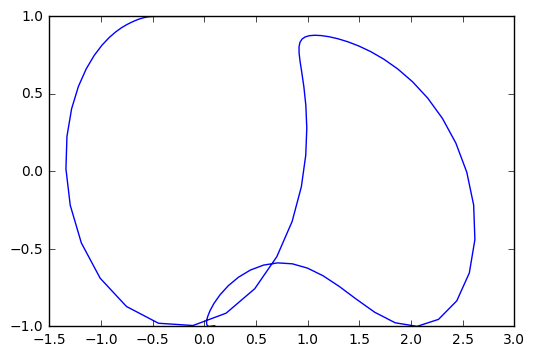

In [7]:
plt.plot(x2[:, 0], x2[:, 1])

### x-displacement over time

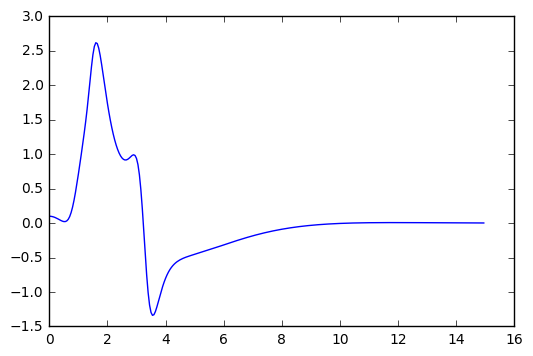

In [8]:
plt.plot(t, x2[:, 0])

### Animation

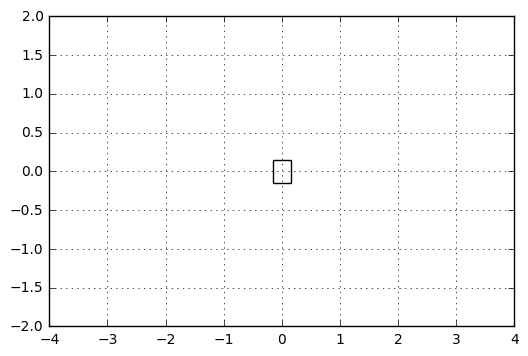

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-4, 4), ylim=(-2, 2)) 
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
box_width = 0.3 
box_height = 0.3 
rect = patches.Rectangle(
    (x1[0, 0] - box_width/2, x1[0, 1] - box_height/2),
    box_width,
    box_height,
    fill=False
)   
ax.add_patch(rect)

def init():
    line.set_data([], []) 
    time_text.set_text('')
    return line, time_text, rect


def animate(i):
    thisx = [x1[i, 0], x2[i, 0]] 
    thisy = [x1[i, 1], x2[i, 1]] 

    line.set_data(thisx, thisy)
    time_text.set_text(time_template % (i*dt))

    rect.set_xy((x1[i, 0] - box_width/2, x1[i, 1] - box_height/2))
    return line, time_text, rect

ani = animation.FuncAnimation(fig, animate, np.arange(len(y)-1),
                              interval=25, blit=False, init_func=init)
ani

Note: see the file `swing-up.mp4` for the animation, which does not render in the github viewer.